In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from support import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import optuna
# from model import SimpleCNN
from train_test_optimize import train_model, test_model, objective_with_cv
from functools import partial

In [2]:
train_data, test_data = load_dataset()

print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

Train data: 136
Test data: 34


In [3]:
# Get a batch of training data
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
images, labels = next(iter(train_loader))

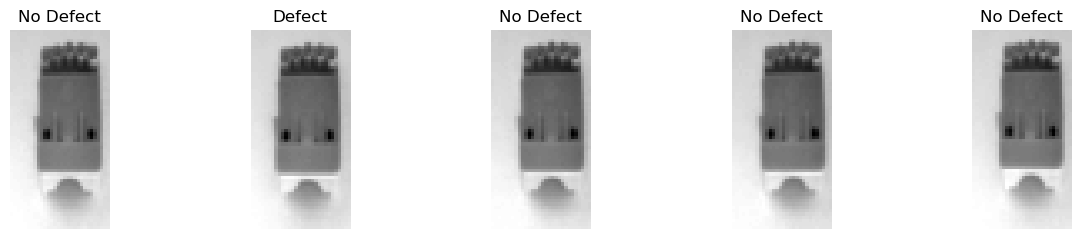

In [4]:
# Define the class labels
class_labels = ["Defect", "No Defect"]

# Create a grid of the images and print the labels
plt.figure(figsize=(15, 15))
for i in range(5):
    plt.subplot(5, 5, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.axis("off")
    plt.title(class_labels[labels[i]])

plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleCNN(nn.Module):
    """
    Simple CNN model for binary classification

    Args:
    - dropout_rate: dropout rate

    Returns:
    - output: predicted probability of the input belonging to the positive class
    """

    def __init__(self, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(3, 3)
        self.fc1 = nn.Linear(16 * 8 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights of the model

        Returns:
        - None
        """
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                nn.init.kaiming_normal_(m.weight, nonlinearity="relu")

    def forward(self, x):
        """
        Forward pass of the model

        Args:
        - x: input tensor

        Returns:
        - x: output tensor
        """
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 8 * 3)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze()


model = SimpleCNN()

In [6]:
# Define global parameters
EPOCHS = 15
N_TRIALS = 2
MODEL = SimpleCNN
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cuda


In [7]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005 , weight_decay=0.0001)

# Move the model to the device
model.to(DEVICE)

# Train the model
train_losses, val_losses = train_model(
    model,
    train_data,
    criterion,
    optimizer,
    DEVICE,
    n_epochs=EPOCHS,
    model_name="initial_model",
    val_split=0.1,
)

Training Epoch 1/15: 100%|██████████| 2/2 [00:20<00:00, 10.42s/it]


Epoch 1, Train Loss: 0.6882, Val Loss: 0.7085, Train Acc: 50.82%, Val Acc: 28.57%


Training Epoch 2/15: 100%|██████████| 2/2 [00:20<00:00, 10.09s/it]


Epoch 2, Train Loss: 0.7097, Val Loss: 0.6508, Train Acc: 48.36%, Val Acc: 64.29%


Training Epoch 3/15: 100%|██████████| 2/2 [00:19<00:00,  9.96s/it]


Epoch 3, Train Loss: 0.6499, Val Loss: 0.7571, Train Acc: 60.66%, Val Acc: 35.71%


Training Epoch 4/15: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]


Epoch 4, Train Loss: 0.6046, Val Loss: 0.6272, Train Acc: 72.13%, Val Acc: 50.00%


Training Epoch 5/15: 100%|██████████| 2/2 [00:19<00:00,  9.88s/it]


Epoch 5, Train Loss: 0.5350, Val Loss: 0.6968, Train Acc: 79.51%, Val Acc: 64.29%


Training Epoch 6/15: 100%|██████████| 2/2 [00:19<00:00,  9.67s/it]


Epoch 6, Train Loss: 0.4718, Val Loss: 0.6625, Train Acc: 81.97%, Val Acc: 64.29%


Training Epoch 7/15: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]


Epoch 7, Train Loss: 0.4231, Val Loss: 0.6987, Train Acc: 81.97%, Val Acc: 64.29%


Training Epoch 8/15: 100%|██████████| 2/2 [00:19<00:00,  9.69s/it]


Epoch 8, Train Loss: 0.4047, Val Loss: 0.7649, Train Acc: 80.33%, Val Acc: 64.29%


Training Epoch 9/15: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]


Epoch 9, Train Loss: 0.3812, Val Loss: 0.8389, Train Acc: 84.43%, Val Acc: 64.29%


Training Epoch 10/15: 100%|██████████| 2/2 [00:19<00:00,  9.66s/it]


Epoch 10, Train Loss: 0.3771, Val Loss: 0.8970, Train Acc: 85.25%, Val Acc: 64.29%


Training Epoch 11/15: 100%|██████████| 2/2 [00:19<00:00, 10.00s/it]


Epoch 11, Train Loss: 0.3386, Val Loss: 0.6761, Train Acc: 86.07%, Val Acc: 71.43%


Training Epoch 12/15: 100%|██████████| 2/2 [00:19<00:00,  9.84s/it]


Epoch 12, Train Loss: 0.3242, Val Loss: 0.5642, Train Acc: 86.07%, Val Acc: 78.57%


Training Epoch 13/15: 100%|██████████| 2/2 [00:20<00:00, 10.02s/it]


Epoch 13, Train Loss: 0.2889, Val Loss: 0.7935, Train Acc: 90.16%, Val Acc: 64.29%


Training Epoch 14/15: 100%|██████████| 2/2 [00:19<00:00,  9.64s/it]


Epoch 14, Train Loss: 0.2783, Val Loss: 0.4675, Train Acc: 87.70%, Val Acc: 85.71%


Training Epoch 15/15: 100%|██████████| 2/2 [00:19<00:00,  9.94s/it]


Epoch 15, Train Loss: 0.2629, Val Loss: 0.4301, Train Acc: 91.80%, Val Acc: 92.86%
Finished Training


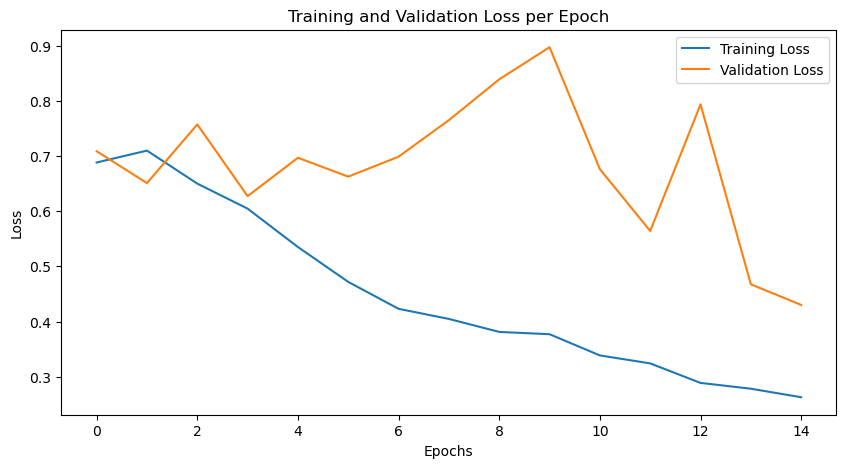

In [8]:
# Visualize the training loss over epochs
plt.figure(figsize=(10, 5))
plt.title("Training and Validation Loss per Epoch")
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
# Test model on the test data and get metrics
accuracy, precision, recall, f1 = test_model(model, test_data, DEVICE)

# Visualize the metrics in a table
metrics = pd.DataFrame(
    {"Accuracy": [accuracy], "Precision": [precision], "Recall": [recall], "F1": [f1]}
)

print(metrics)

Testing: 100%|██████████| 1/1 [00:05<00:00,  5.55s/it]

   Accuracy  Precision    Recall   F1
0  0.764706   0.695652  0.941176  0.8
